In [147]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [148]:
def read_file(path):
  """
  Read the text file and return as dataframe
  """
  file = open(path, "r")
  s = file.readlines()
  input = []
  emotions = []
  for row in s:
    x = row.split(";")
    input.append(x[0])
    emotions.append(x[1][:-1])
  df = pd.DataFrame({"input_text":input,"emotions":emotions})
  return df

In [149]:
# file paths
train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

In [150]:
# reading the train, test and validation file
df_test = read_file(test_path)
df_train = read_file(train_path)
df_val = read_file(val_path)

In [151]:
print(os.listdir())

['.config', 'train.txt', 'test.txt', 'val.txt', 'sample_data']


In [152]:
print(f"train : {df_train.shape}\ntest: {df_test.shape}\nValidation: {df_val.shape}")

train : (16000, 2)
test: (2000, 2)
Validation: (2000, 2)


In [153]:
df_train.head()

,input_text,emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [154]:
# Remove missing values (NaN)
df_train = df_train[pd.notnull(df_train['input_text'])]
df_test = df_test[pd.notnull(df_test['input_text'])]
df_val = df_val[pd.notnull(df_val['input_text'])]

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(16000, 2)
(2000, 2)
(2000, 2)


In [155]:
# Create a copy of each dataframe
df_train1 = df_train.copy()
df_test1 = df_test.copy()
df_val1 = df_val.copy()

In [156]:
# number of emotions class
pd.DataFrame(df_train1.emotions.unique()).values

array([['sadness'],
       ['anger'],
       ['love'],
       ['surprise'],
       ['fear'],
       ['joy']], dtype=object)

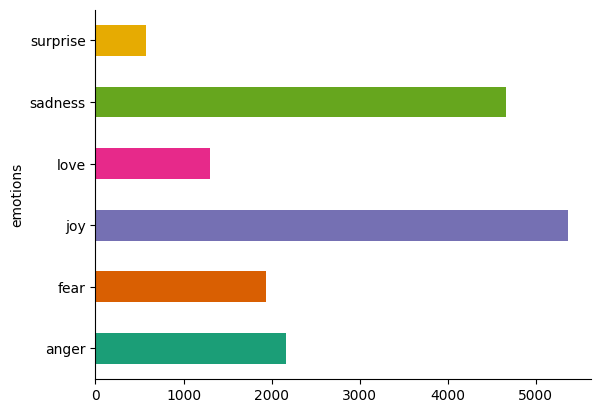

In [157]:
# getting the distribution of emotions
from matplotlib import pyplot as plt
import seaborn as sns
df_train1.groupby('emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [158]:
# get the percantage of each emotion
df_train1["emotions"].value_counts()/df_train1.shape[0] * 100

joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: emotions, dtype: float64

We can see that there is class imbalance in data




In [159]:
input = "input_text"
target = "emotions"
encoded_target = "sentiment_id"

In [160]:
# preprocessing steps
class preprocessing:
  def __init__(self, df, col):
    self.df = df
    self.col = col
    self.col_clean = col
    self.lower_case()
    self.tokenize_sentence()
    self.stem()
    self.remove_non_alpha()
    self.remove_stopwords()
  def lower_case(self):
    # Lowercase the text
    self.df[self.col_clean] = self.df[self.col].str.lower()
  def tokenize_sentence(self):
    # Tokenize the text
    self.df[self.col_clean] = self.df[self.col].apply(nltk.word_tokenize)
  def remove_stopwords(self):
    # Remove stopwords
    self.df[self.col_clean] = self.df[self.col_clean].apply(lambda x: " ".join([char for char in x if char not in stopwords.words('english')]))
  def remove_non_alpha(self):
    # Remove punctuation and other no aphabetic characters from tokens
    self.df[self.col_clean] = self.df[self.col_clean].apply(lambda x: [char for char in x if char.isalpha()])
  def stem(self):
    # Convert the tokenized words into its base form
    lm = nltk.WordNetLemmatizer()
    self.df[self.col_clean] = self.df[self.col_clean].apply(lambda x: [lm.lemmatize(word) for word in x])

In [161]:
df_train1 = preprocessing(df_train1, input)
df_test1 = preprocessing(df_test1, input)
df_val1 = preprocessing(df_val1, input)

In [162]:
df_train1 = df_train1.df
df_test1 = df_test1.df
df_val1 = df_val1.df

In [163]:
# Create a new column 'sentiment_id' with encoded categories
def encode_target(df, target_col, encoded_target):
  df[encoded_target] = df[target_col].factorize()[0]
  return df

In [164]:
df_train1 = encode_target(df_train1, target, encoded_target)
df_test1 = encode_target(df_test1, target, encoded_target)
df_val1 = encode_target(df_val1, target, encoded_target)

In [165]:
df_train1.head()

,input_text,emotions,sentiment_id
0,didnt feel humiliated,sadness,0
1,go feeling hopeless damned hopeful around some...,sadness,0
2,im grabbing minute post feel greedy wrong,anger,1
3,ever feeling nostalgic fireplace know still pr...,love,2
4,feeling grouchy,anger,1


In [166]:

def vectorize_X(df, input, max_words):
  tfidf = TfidfVectorizer(max_features=max_words,sublinear_tf=True, min_df=5,
                          ngram_range=(1, 2),
                          stop_words='english')

  # We transform each complaint into a vector
  X = tfidf.fit_transform(df[input]).toarray()
  print("Each of the %d input_text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(X.shape))
  return X, tfidf

In [167]:
# converting data to vector
max_words = 1500

In [168]:
labels = df_train1.sentiment_id
X_train, tfidf = vectorize_X(df_train1, input, max_words)  # training data input
y_train = df_train1[encoded_target] # training data target
X_val = tfidf.transform(df_val1[input]).toarray() # validation data input
y_val = df_val1[encoded_target] #  validation target
X_test = tfidf.transform(df_test1[input]).toarray() # test data input
y_test = df_test1[encoded_target] # test data target

Each of the 16000 input_text is represented by 1500 features (TF-IDF score of unigrams and bigrams)


In [169]:
X_test.shape

(2000, 1500)

In [170]:
# models class having all the models
class Models:
  def __init__(self, X_train, y_train, weights=None):
    self.X_train = X_train
    self.y_train = y_train
    self.weights_dict = weights

  def linearSVC(self):
    # Linear Support Vector Classification
    clf = LinearSVC(penalty='l2', C=1.0, class_weight=self.weights_dict)
    clf.fit(self.X_train, self.y_train)
    return clf

  def naive_bayes(self):
    # Naive Bayes
    clf = MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)
    clf.fit(self.X_train, self.y_train)
    return clf

  def random_forest(self):
    # Random Forest
    clf = RandomForestClassifier(n_estimators=100, criterion='entropy',
                                 bootstrap=False, class_weight=self.weights_dict)
    clf.fit(self.X_train, self.y_train)
    return clf

  def knn(self):
    # K-Nearest Neighbors
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(self.X_train, self.y_train)
    return clf

In [171]:
models = Models(X_train, y_train)
svc = models.linearSVC()
nb = models.naive_bayes()
rf = models.random_forest()
knn = models.knn()

In [172]:
# Classification report
def report(y_pred, y_test):
  print('\t\t\t\tCLASSIFICATIION METRICS\n')
  print(metrics.classification_report(y_test, y_pred,
                                      target_names= df_train1['emotions'].unique()))

In [173]:
# svc report on validation data
y_pred = svc.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.88      0.93      0.90       550
       anger       0.01      0.02      0.01       178
        love       0.01      0.01      0.01       275
    surprise       0.04      0.00      0.01       704
        fear       0.85      0.82      0.83       212
         joy       0.01      0.05      0.01        81

    accuracy                           0.35      2000
   macro avg       0.30      0.30      0.30      2000
weighted avg       0.35      0.35      0.34      2000



In [174]:
# svc report on test data
y_pred = svc.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.90      0.93      0.92       581
       anger       0.02      0.01      0.01       695
        love       0.01      0.01      0.01       224
    surprise       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       159
         joy       0.02      0.17      0.03        66

    accuracy                           0.28      2000
   macro avg       0.16      0.18      0.16      2000
weighted avg       0.27      0.28      0.27      2000



In [175]:
# naive bayes report on validation set
y_pred = nb.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.83      0.94      0.88       550
       anger       0.02      0.02      0.02       178
        love       0.01      0.00      0.01       275
    surprise       0.00      0.00      0.00       704
        fear       0.86      0.73      0.79       212
         joy       0.02      0.25      0.04        81

    accuracy                           0.35      2000
   macro avg       0.29      0.32      0.29      2000
weighted avg       0.32      0.35      0.33      2000



In [176]:
# naive bayes report on test data
y_pred = nb.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.87      0.93      0.90       581
       anger       0.00      0.00      0.00       695
        love       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       159
         joy       0.03      0.35      0.05        66

    accuracy                           0.28      2000
   macro avg       0.15      0.21      0.16      2000
weighted avg       0.25      0.28      0.26      2000



In [177]:
# rf report on validation data
y_pred = rf.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.91      0.87      0.89       550
       anger       0.00      0.01      0.00       178
        love       0.01      0.00      0.00       275
    surprise       0.03      0.00      0.01       704
        fear       0.78      0.84      0.81       212
         joy       0.01      0.09      0.02        81

    accuracy                           0.33      2000
   macro avg       0.29      0.30      0.29      2000
weighted avg       0.34      0.33      0.33      2000



In [178]:
# rf report on test data
y_pred = rf.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.92      0.86      0.89       581
       anger       0.03      0.01      0.01       695
        love       0.01      0.01      0.01       224
    surprise       0.02      0.00      0.01       275
        fear       0.00      0.00      0.00       159
         joy       0.02      0.20      0.03        66

    accuracy                           0.26      2000
   macro avg       0.17      0.18      0.16      2000
weighted avg       0.28      0.26      0.27      2000



In [179]:
# knn report on validation data
y_pred = knn.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.78      0.54      0.64       550
       anger       0.04      0.04      0.04       178
        love       0.01      0.00      0.01       275
    surprise       0.04      0.00      0.01       704
        fear       0.19      0.80      0.31       212
         joy       0.02      0.11      0.03        81

    accuracy                           0.24      2000
   macro avg       0.18      0.25      0.17      2000
weighted avg       0.26      0.24      0.22      2000



In [180]:
# knn report on test data
y_pred = knn.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.80      0.56      0.66       581
       anger       0.09      0.02      0.04       695
        love       0.01      0.00      0.01       224
    surprise       0.00      0.00      0.00       275
        fear       0.08      0.45      0.14       159
         joy       0.01      0.08      0.02        66

    accuracy                           0.21      2000
   macro avg       0.17      0.18      0.14      2000
weighted avg       0.27      0.21      0.22      2000



We have seen that we have data imbalance issue. We will try to deal with is in different ways:
1. Try to use sampling techniques to generate data for minority classes
2. Try to catogorized the emotions into into following categories:
  a.Positive : love, joy
  b.Negative: fear, anger, sadness
  c.Neutral: surprise
3. We can assign weights to minority classes

Trying to use sampling techniques to generate data for minority classes

In [181]:
# generating data for minority class
def sampling(df):
  df_joy = df[df['emotions'] == 'joy']
  df_love = df[df['emotions'] == 'love']
  df_anger = df[df['emotions'] == 'anger']
  df_fear = df[df['emotions'] == 'fear']
  df_sadness = df[df['emotions'] == 'sadness']
  df_surprise = df[df['emotions'] == 'surprise']
  df_joy_oversampled = df_joy.sample(df_anger.shape[0], replace=True)
  df_love_oversampled = df_love.sample(df_anger.shape[0], replace=True)
  df_oversampled = pd.concat([df_anger, df_fear, df_sadness, df_surprise, df_joy_oversampled, df_love_oversampled], axis=0)
  return df_oversampled

In [182]:
df_oversampled = sampling(df_train)
print(df_oversampled.shape)

(13652, 2)


In [183]:
# now distributions looks better than the previous distribution
df_oversampled["emotions"].value_counts()/df_oversampled.shape[0] * 100

sadness     34.178142
anger       15.814533
joy         15.814533
love        15.814533
fear        14.188397
surprise     4.189862
Name: emotions, dtype: float64

In [184]:
df_oversampled = encode_target(df_oversampled, target, encoded_target)

In [185]:
X_train, tfidf = vectorize_X(df_oversampled, input, max_words)  # training data input
y_train = df_oversampled[encoded_target] # training data target

Each of the 13652 input_text is represented by 1500 features (TF-IDF score of unigrams and bigrams)


In [186]:
models = Models(X_train, y_train)
svc = models.linearSVC()
nb = models.naive_bayes()
rf = models.random_forest()
knn = models.knn()

In [187]:
# svc report on validation data
y_pred = svc.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.27      0.15      0.19       550
       anger       0.09      0.15      0.11       178
        love       0.14      0.41      0.21       275
    surprise       0.31      0.03      0.05       704
        fear       0.09      0.15      0.11       212
         joy       0.01      0.02      0.02        81

    accuracy                           0.14      2000
   macro avg       0.15      0.15      0.11      2000
weighted avg       0.22      0.14      0.12      2000



In [188]:
# svc report on test data
y_pred = svc.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.27      0.14      0.19       581
       anger       0.29      0.13      0.18       695
        love       0.11      0.38      0.18       224
    surprise       0.05      0.01      0.02       275
        fear       0.09      0.23      0.13       159
         joy       0.01      0.03      0.02        66

    accuracy                           0.15      2000
   macro avg       0.14      0.15      0.12      2000
weighted avg       0.21      0.15      0.15      2000



In [189]:
# nb report on validation data
y_pred = nb.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.27      0.13      0.17       550
       anger       0.09      0.12      0.10       178
        love       0.15      0.53      0.23       275
    surprise       0.31      0.02      0.03       704
        fear       0.09      0.09      0.09       212
         joy       0.03      0.10      0.05        81

    accuracy                           0.14      2000
   macro avg       0.15      0.16      0.11      2000
weighted avg       0.22      0.14      0.11      2000



In [190]:
# nb report on test data
y_pred = nb.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.24      0.11      0.15       581
       anger       0.31      0.11      0.16       695
        love       0.11      0.46      0.17       224
    surprise       0.04      0.00      0.01       275
        fear       0.12      0.17      0.14       159
         joy       0.02      0.09      0.04        66

    accuracy                           0.14      2000
   macro avg       0.14      0.16      0.11      2000
weighted avg       0.20      0.14      0.13      2000



In [191]:
# rf report on validation data
y_pred = rf.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.26      0.18      0.21       550
       anger       0.08      0.46      0.14       178
        love       0.19      0.15      0.16       275
    surprise       0.29      0.03      0.05       704
        fear       0.08      0.05      0.06       212
         joy       0.03      0.07      0.04        81

    accuracy                           0.13      2000
   macro avg       0.15      0.16      0.11      2000
weighted avg       0.22      0.13      0.12      2000



In [192]:
# rf report on test data
y_pred = rf.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.30      0.19      0.23       581
       anger       0.34      0.48      0.40       695
        love       0.10      0.10      0.10       224
    surprise       0.06      0.01      0.02       275
        fear       0.12      0.10      0.11       159
         joy       0.01      0.03      0.01        66

    accuracy                           0.24      2000
   macro avg       0.15      0.15      0.14      2000
weighted avg       0.23      0.24      0.23      2000



In [193]:
# knn report on validation data
y_pred = knn.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.27      0.91      0.42       550
       anger       0.17      0.02      0.04       178
        love       0.13      0.04      0.06       275
    surprise       0.20      0.00      0.00       704
        fear       0.06      0.01      0.02       212
         joy       0.00      0.00      0.00        81

    accuracy                           0.26      2000
   macro avg       0.14      0.16      0.09      2000
weighted avg       0.18      0.26      0.13      2000



In [194]:
# knn report on test data
y_pred = knn.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     sadness       0.29      0.90      0.44       581
       anger       0.40      0.01      0.02       695
        love       0.06      0.02      0.03       224
    surprise       0.00      0.00      0.00       275
        fear       0.11      0.03      0.04       159
         joy       0.00      0.00      0.00        66

    accuracy                           0.27      2000
   macro avg       0.14      0.16      0.09      2000
weighted avg       0.24      0.27      0.14      2000



Trying to catogorized the emotions into into following categories: a.Positive : love, joy b.Negative: fear, anger, sadness c.Neutral: surprise

In [195]:
# convert the emotions into 3 categories
def categorize(df, col):
  df[col] = df[col].replace({
      'sadness': 'negative',
      'anger': 'negative',
      'fear': 'negative',
      'love': 'positive',
      'joy': 'positive',
      'surprise': 'neutral'
  })
  return df

In [196]:
df_train1 = df_train.copy()
df_test1 = df_test.copy()
df_val1 = df_val.copy()

In [197]:
# convert to 3 class
df_train1 = categorize(df_train1, target)
df_test1 = categorize(df_test1, target)
df_val1 = categorize(df_val1, target)

In [198]:
df_train1 = preprocessing(df_train1, input)
df_test1 = preprocessing(df_test1, input)
df_val1 = preprocessing(df_val1, input)

df_train1 = df_train1.df
df_test1 = df_test1.df
df_val1 = df_val1.df

In [199]:
df_train1 = encode_target(df_train1, target, encoded_target)
df_test1 = encode_target(df_test1, target, encoded_target)
df_val1 = encode_target(df_val1, target, encoded_target)

In [200]:
labels = df_train1.sentiment_id
X_train, tfidf = vectorize_X(df_train1, input, max_words)  # training data input
y_train = df_train1[encoded_target] # training data target
X_val = tfidf.transform(df_val1[input]).toarray() # validation data input
y_val = df_val1[encoded_target] #  validation target
X_test = tfidf.transform(df_test1[input]).toarray() # test data input
y_test = df_test1[encoded_target] # test data target

Each of the 16000 input_text is represented by 1500 features (TF-IDF score of unigrams and bigrams)


In [201]:
models = Models(X_train, y_train)
svc = models.linearSVC()
nb = models.naive_bayes()
rf = models.random_forest()
knn = models.knn()

In [202]:
# svc report on validation data
y_pred = svc.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.93      0.96      0.95      1037
    positive       0.96      0.93      0.94       882
     neutral       0.82      0.77      0.79        81

    accuracy                           0.94      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.94      0.94      0.94      2000



In [203]:
# svc report on test data
y_pred = svc.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      1080
    positive       0.95      0.95      0.95       854
     neutral       0.84      0.64      0.72        66

    accuracy                           0.95      2000
   macro avg       0.92      0.85      0.88      2000
weighted avg       0.95      0.95      0.95      2000



In [204]:
# nb report on validation data
y_pred = nb.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.91      0.98      0.94      1037
    positive       0.95      0.92      0.94       882
     neutral       0.96      0.32      0.48        81

    accuracy                           0.93      2000
   macro avg       0.94      0.74      0.79      2000
weighted avg       0.93      0.93      0.92      2000



In [205]:
# nb report on test data
y_pred = nb.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.93      0.97      0.95      1080
    positive       0.95      0.94      0.94       854
     neutral       1.00      0.26      0.41        66

    accuracy                           0.94      2000
   macro avg       0.96      0.72      0.77      2000
weighted avg       0.94      0.94      0.93      2000



In [206]:
# rf report on validation data
y_pred = rf.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.91      0.95      0.93      1037
    positive       0.94      0.90      0.92       882
     neutral       0.82      0.81      0.82        81

    accuracy                           0.92      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.92      0.92      0.92      2000



In [207]:
# rf report on test data
y_pred = rf.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.93      0.94      0.94      1080
    positive       0.94      0.93      0.93       854
     neutral       0.66      0.62      0.64        66

    accuracy                           0.93      2000
   macro avg       0.84      0.83      0.84      2000
weighted avg       0.93      0.93      0.93      2000



In [208]:
# knn report on validation data
y_pred = knn.predict(X_val)
report(y_pred, y_val)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.68      0.96      0.80      1037
    positive       0.92      0.52      0.66       882
     neutral       0.79      0.38      0.52        81

    accuracy                           0.74      2000
   macro avg       0.80      0.62      0.66      2000
weighted avg       0.79      0.74      0.73      2000



In [209]:
# knn report on test data
y_pred = knn.predict(X_test)
report(y_pred, y_test)

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    negative       0.70      0.96      0.81      1080
    positive       0.92      0.52      0.67       854
     neutral       0.83      0.30      0.44        66

    accuracy                           0.75      2000
   macro avg       0.82      0.60      0.64      2000
weighted avg       0.80      0.75      0.74      2000



In [210]:
weights = df_train1[encoded_target].value_counts()/len(df_train1)
weights_dict = weights.to_dict()
weights_dict

{0: 0.547625, 1: 0.416625, 2: 0.03575}